# Modelos IPR Avanzados (Standing y Jones)

En esta etapa se amplían los modelos de desempeño de afluencia (IPR) de la librería **PetroKit**, 
incorporando correlaciones más realistas utilizadas en la industria petrolera.

Los modelos considerados son:

- **Standing (1970)** → Representa pozos bajo empuje por gas disuelto, considerando el comportamiento no lineal entre presión y caudal.  
- **Jones (1976)** → Describe pozos con daño o estimulación, introduciendo el concepto de *skin*.

Estas correlaciones permiten comparar comportamientos productivos bajo distintas condiciones de formación.


In [21]:
import numpy as np
import matplotlib.pyplot as plt

Utilizamos **NumPy** para el manejo de arreglos y operaciones matemáticas vectorizadas,  
y **Matplotlib** para la visualización de las curvas de desempeño (IPR).

Todas las funciones se diseñan para ser modulares y compatibles con la futura arquitectura de `petrokit.ipr`.


In [27]:
def standing_ipr(p_res, q_max, pwf, n=1.8):
    if p_res <= 0 or q_max <= 0:
        raise ValueError("p_res y q_max deben ser positivos")
    if n <= 0:
        raise ValueError("El exponente n debe ser positivo")

    pwf = np.array(pwf, dtype=float)
    q = q_max * (1 - (pwf / p_res) ** n)
    q = np.where(q < 0, 0, q) 
    return q

El modelo de **Standing (1970)** describe el flujo bajo empuje por gas en solución:

\[
q = q_{max} \left(1 - \left(\frac{p_{wf}}{p_{res}}\right)^n\right)
\]

donde:
- \( q_{max} \): caudal máximo a presión fluyente cero  
- \( n \): exponente empírico (≈ 1.6 a 2.0)  
- \( p_{wf} \): presión de fondo fluyente  
- \( p_{res} \): presión del yacimiento  

El exponente \( n \) controla la **curvatura** de la relación entre presión y caudal.  
A mayor \( n \), más pronunciada es la caída del caudal con la presión.


In [23]:
def jones_ipr(p_res, J, pwf, s=0):
    if p_res <= 0 or J <= 0:
        raise ValueError("p_res y J deben ser positivos")
    if (1 + s) <= 0:
        raise ValueError("El factor (1+s) debe ser positivo")

    pwf = np.array(pwf, dtype=float)
    delta_p = p_res - pwf
    delta_p = np.where(delta_p < 0, 0, delta_p)  # 👈 igual aquí
    J_eff = J / (1 + s)
    q = J_eff * delta_p
    return q

El modelo de **Jones (1976)** incorpora el efecto de *skin*, que representa el daño o estimulación alrededor del pozo:

q = J_{eff} (p_{res} - p_{wf}), \quad J_{eff} = \frac{J}{1+s}

donde:
- \( J \): índice de productividad [STB/d/psi]  
- \( s \): factor de daño (*s>0*) o estimulación (*s<0*)  
- \( J_{eff} \): productividad efectiva  

Este modelo es **lineal**, pero ajusta la pendiente según el estado del pozo (dañado o estimulado).


In [24]:
def ipr_curve(model, p_res, **kwargs):
    pwf_range = np.linspace(0, p_res, 30)
    q_range = [model(p_res, pwf=p, **kwargs) for p in pwf_range]
    return pwf_range, np.array(q_range)

def plot_ipr(models, p_res, labels=None, kwargs_list=None):
    plt.figure(figsize=(7, 5))
    for i, model in enumerate(models):
        args = kwargs_list[i] if kwargs_list else {}
        pwf, q = ipr_curve(model, p_res, **args)
        plt.plot(q, pwf, linewidth=2, label=labels[i] if labels else f'Modelo {i+1}')
    plt.xlabel('Caudal q [STB/d]')
    plt.ylabel('Presión pwf [psi]')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.title('Comparación de curvas IPR avanzadas')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Estas funciones permiten generar y graficar múltiples curvas IPR.

- `ipr_curve()` calcula los pares (pwf, q) para un modelo dado.  
- `plot_ipr()` compara varios modelos en un mismo gráfico, facilitando la visualización técnica.

La inversión del eje Y refleja la práctica habitual en ingeniería de producción:  
**a menor presión de fondo fluyente, mayor caudal**.


In [25]:
def plot_standing_sensitivity(p_res, q_max, n_values=[1.6, 1.8, 2.0]):
    plt.figure(figsize=(7, 5))
    for n in n_values:
        pwf, q = ipr_curve(standing_ipr, p_res, q_max=q_max, n=n)
        plt.plot(q, pwf, label=f'Standing (n={n})')
    plt.xlabel('Caudal q [STB/d]')
    plt.ylabel('Presión pwf [psi]')
    plt.title('Sensibilidad modelo Standing')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

def plot_jones_sensitivity(p_res, J, s_values=[-0.5, 0, 2]):
    plt.figure(figsize=(7, 5))
    for s in s_values:
        pwf, q = ipr_curve(jones_ipr, p_res, J=J, s=s)
        plt.plot(q, pwf, label=f'Jones (s={s})')
    plt.xlabel('Caudal q [STB/d]')
    plt.ylabel('Presión pwf [psi]')
    plt.title('Sensibilidad modelo Jones (skin)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

Se definen dos funciones de análisis de sensibilidad:

- **`plot_standing_sensitivity()`**: evalúa cómo el exponente *n* afecta la curva IPR de Standing.  
  Un mayor *n* implica mayor no linealidad y menor caudal a presiones intermedias.  

- **`plot_jones_sensitivity()`**: analiza el impacto del *skin* en la productividad.  
  Valores negativos (*estimulación*) aumentan el caudal; positivos (*daño*) lo reducen.


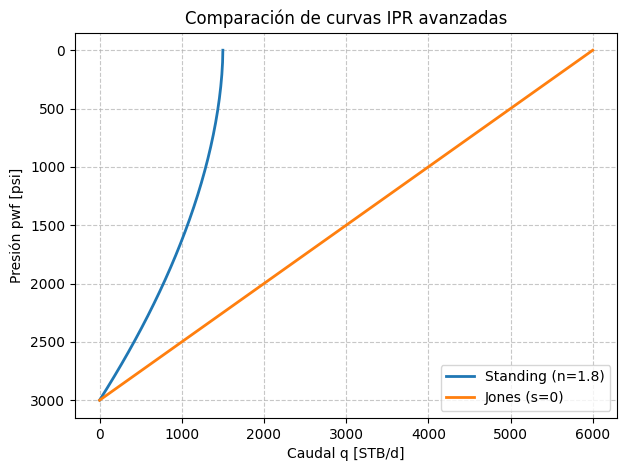

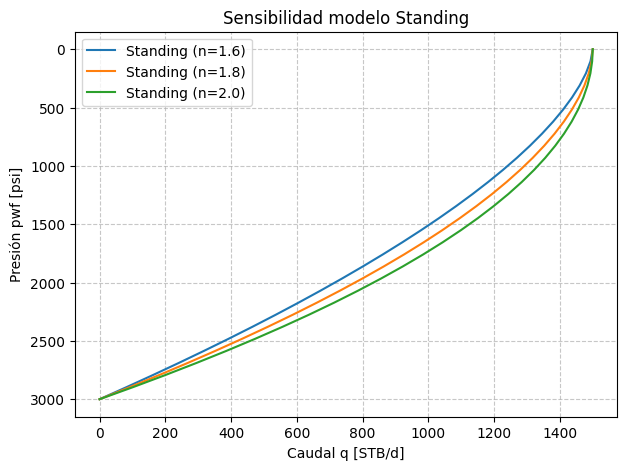

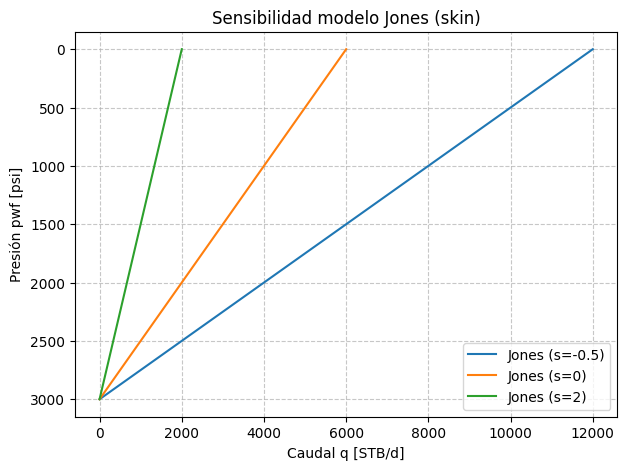

In [26]:
p_res = 3000  # psi
q_max = 1500  # STB/d
J = 2.0       # STB/d/psi

plot_ipr(
    models=[standing_ipr, jones_ipr],
    p_res=p_res,
    labels=['Standing (n=1.8)', 'Jones (s=0)'],
    kwargs_list=[{'q_max': q_max, 'n': 1.8}, {'J': J, 's': 0}]
)

plot_standing_sensitivity(p_res=p_res, q_max=q_max)
plot_jones_sensitivity(p_res=p_res, J=J)

En este ejemplo se comparan los modelos de Standing y Jones bajo condiciones iguales de presión y caudal máximo.

Posteriormente se ejecutan análisis de sensibilidad que muestran:

- Cómo varía la curva de Standing al modificar el exponente \( n \).  
- Cómo afecta el factor de *skin* en la productividad de Jones.


# Conclusiones

- El modelo de **Standing** representa el flujo bajo drive por gas disuelto, 
  y muestra un comportamiento no lineal controlado por el exponente *n*.

- El modelo de **Jones** permite representar daño o estimulación mediante el factor *skin*, 
  manteniendo una relación lineal entre presión y caudal.

- Ambas correlaciones son esenciales para análisis nodales y diagnóstico de productividad.

